Saved GIF with 18 frames to: ./arc_env_obs.gif


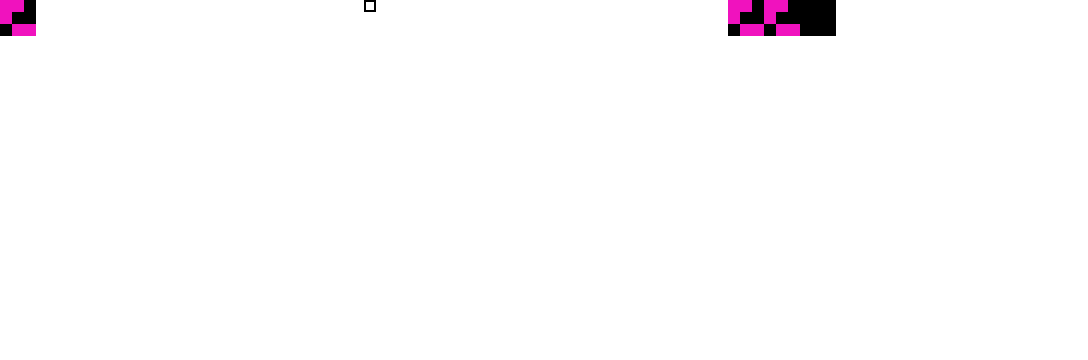

In [2]:
import os
# Force CPU to avoid Metal PJRT plugin mismatch
os.environ["JAX_PLATFORMS"] = "cpu"
os.environ.setdefault("JAX_PLATFORM_NAME", "cpu")

import sys
sys.path.append("..")

import jax
import jax.numpy as jnp
import numpy as np

try:
    import imageio.v2 as imageio
except Exception:
    import subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "imageio"])  # noqa: E402
    import imageio.v2 as imageio

from IPython.display import Image, display

from env import ARCEnv
from env.wrappers import observe

# Minimal inline ARC example
json_str = """
{
  "train": [
    {
      "input": [[6,6,0],[6,0,0],[0,6,6]],
      "output": [[6,6,0,6,6,0,0,0,0],[6,0,0,6,0,0,0,0,0],[0,6,6,0,6,6,0,0,0]]
    }
  ],
  "test": []
}
"""

# Build env and reset
env = ARCEnv.from_json(json_str, max_steps=200)
state = env.env_reset(jax.random.PRNGKey(0), train=True)

# Plan a deterministic sequence: scan the bounding box of non-pad cells in the input
# and copy each cell to the canvas (action 14) in row-major order.
def plan_copy_scan_actions(inp_array: np.ndarray, start_cursor=(0, 0)):
    # Identify non-pad area (values >= 0)
    mask = inp_array >= 0
    ys, xs = np.where(mask)
    if ys.size == 0:
        return []
    rmin, rmax = int(ys.min()), int(ys.max())
    cmin, cmax = int(xs.min()), int(xs.max())

    actions = []
    cur_r, cur_c = start_cursor

    def move_to(target_r: int, target_c: int):
        nonlocal cur_r, cur_c, actions
        # Vertical moves
        while cur_r < target_r:
            actions.append(1)  # down
            cur_r += 1
        while cur_r > target_r:
            actions.append(0)  # up
            cur_r -= 1
        # Horizontal moves
        while cur_c < target_c:
            actions.append(3)  # right
            cur_c += 1
        while cur_c > target_c:
            actions.append(2)  # left
            cur_c -= 1

    for r in range(rmin, rmax + 1):
        # Sweep left->right for even rows, right->left for odd rows (snake) to reduce moves
        if (r - rmin) % 2 == 0:
            cols = range(cmin, cmax + 1)
        else:
            cols = range(cmax, cmin - 1, -1)
        for c in cols:
            move_to(r, c)
            actions.append(14)  # copy from input

    return actions

# Collect observations while executing the planned actions
obs_frames = [np.array(observe(state))]

inp_np = np.array(state.inp)
planned_actions = plan_copy_scan_actions(inp_np, start_cursor=(int(state.cursor[0]), int(state.cursor[1])))

# Respect episode step budget
planned_actions = planned_actions[: int(env.max_steps)]

for a in planned_actions:
    state, reward, done = env.env_step(state, jnp.array(a))
    obs_frames.append(np.array(observe(state)))
    if bool(done):
        break

# Palette from env.env_render
palette_hex = [
    "#000000",  # 0 black
    "#0074D9",  # 1 blue
    "#FF4136",  # 2 red
    "#2ECC40",  # 3 green
    "#FFDC00",  # 4 yellow
    "#AAAAAA",  # 5 grey
    "#F012BE",  # 6 fuchsia
    "#FF851B",  # 7 orange
    "#7FDBFF",  # 8 light blue
    "#870C25",  # 9 burgundy
    "#FFFFFF",  # 10 for -1 (pad)
]

palette = np.array([
    tuple(int(h[i:i+2], 16) for i in (1, 3, 5)) for h in palette_hex
], dtype=np.uint8)


def grid_to_rgb(grid: np.ndarray, cell_size: int = 12) -> np.ndarray:
    idx = np.where(grid < 0, 10, grid).astype(np.int32)
    rgb = palette[idx]  # (H, W, 3)
    # Upscale for visibility
    rgb = np.repeat(np.repeat(rgb, cell_size, axis=0), cell_size, axis=1)
    return rgb


def render_frame_from_obs(obs: np.ndarray, cell_size: int = 12) -> np.ndarray:
    canvas, inp, target, cursor_mask = obs[0], obs[1], obs[2], obs[3]
    # Derive cursor from mask
    pos = np.argwhere(cursor_mask == 1)
    cursor_rc = tuple(pos[0]) if pos.size > 0 else None

    img_in = grid_to_rgb(inp, cell_size)
    img_cv = grid_to_rgb(canvas, cell_size)
    img_tg = grid_to_rgb(target, cell_size)

    # Overlay a border on the cursor cell in the canvas image
    if cursor_rc is not None:
        r, c = cursor_rc
        cs = cell_size
        r0, r1 = r * cs, (r + 1) * cs
        c0, c1 = c * cs, (c + 1) * cs
        border = (0, 0, 0)
        img_cv[r0:r1, c0:c0 + 2] = border
        img_cv[r0:r1, c1 - 2:c1] = border
        img_cv[r0:r0 + 2, c0:c1] = border
        img_cv[r1 - 2:r1, c0:c1] = border

    # Concatenate side-by-side: input | canvas | target
    spacer = 4
    H, W, _ = img_in.shape
    sep = np.full((H, spacer, 3), 255, dtype=np.uint8)
    composite = np.concatenate([img_in, sep, img_cv, sep, img_tg], axis=1)
    return composite

# Build GIF frames
frames = [render_frame_from_obs(f) for f in obs_frames]
out_path = os.path.join(os.path.dirname(__file__) if "__file__" in globals() else ".", "arc_env_obs.gif")
imageio.mimsave(out_path, frames, duration=0.15)

print(f"Saved GIF with {len(frames)} frames to: {out_path}")
display(Image(filename=out_path))


information_bottleneck.ipynb  test_env.ipynb
